1\. **Radioactive decay chain**

${\rm Tl}^{208}$ decays to ${\rm Pb}^{208}$ with a half-lieve of 3.052 minutes. Suppose to start with a sample of 1000 Thallium atoms and 0 of Lead atoms.

* Take steps in time of 1 second and at each time-step decide whether each Tl atom has decayed or not, accordingly to the probability $p(t)=1-2^{-t/\tau}$. Subtract the total number of Tl atoms that decayed at each step from the Tl sample and add them to the Lead one. Plot the evolution of the two sets as a function of time  
* Repeat the exercise by means of the inverse transform method: draw 1000 random numbers from the non-uniform probability distribution $p(t)=2^{-t/\tau}\frac{\ln 2}{\tau}$ to represent the times of decay of the 1000 Tl atoms. Make a plot showing the number of atoms that have not decayed as a function of time

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.stats as stats
import scipy.optimize as optimize
import math
from scipy import integrate

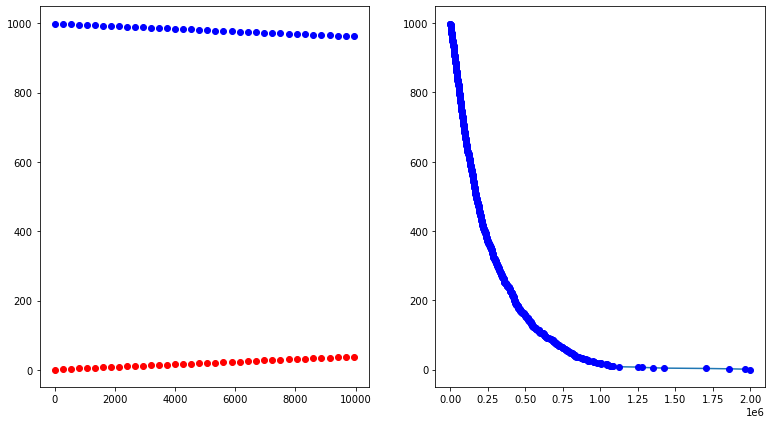

In [3]:
#COSMETICS GRAFICI!!

#t = np.arange(183120)
#t2 = np.arange(1,183121)
t = np.arange(10000)
t2 = np.arange(1,10001)
def N(t, Ni, tau):
    return Ni*pow(2,-t/tau)
Ni_Ti=1000
tau_Ti=183120
NTi=np.array(N(t,Ni_Ti,tau_Ti))
NPb=np.array(Ni_Ti-NTi)
DN=((NTi).astype(int)-(N(t2,Ni_Ti,tau_Ti)).astype(int))

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13,7))

Ti=np.array([1]*Ni_Ti)
Pb_list= []
for i in t:
    if DN[i]>0:
        rnd_indexes = random.sample(range(0, len(Ti)), DN[i])
        Ti=np.delete(Ti,rnd_indexes)
        Pb_list.append(1*DN[i])
        ax1.plot(t[i],len(Ti),linewidth=None,marker='o', markeredgecolor='blue', markerfacecolor='blue')
        ax1.plot(t[i],len(Pb_list),linewidth=None,marker='o', markeredgecolor='red', markerfacecolor='red')
Pb=np.array(Pb_list)

def decay_icdf(p, tau):
    return -tau*np.log2(1-p)
u = np.random.random(Ni_Ti)
decay_times = np.sort(decay_icdf(u,tau_Ti))
Ti_count=np.array(list(reversed(range(0,1000))))                 

ax2.plot(decay_times,Ti_count,linewidth=None,marker='o', markeredgecolor='blue', markerfacecolor='blue')
plt.show()

2\. **Rutherford Scattering**

The scattering angle $\theta$ of $\alpha$ particles hitting a positively charged nucleus of a Gold atom ($Z=79$) follows the rule:

$$
\tan{\frac{1}{2} \theta} = \frac{Z e^2} {2\pi \epsilon_0 E b}
$$

where $E=7.7$ MeV and $b$ beam is the impact parameter. The beam is represented by a 2D gaussian distribution with $\sigma=a_0/100$ for both coordinates ($a_0$ being the Bohr radius). Assume 1 million $\alpha$ particles are shot on the gold atom.

Computing the fraction of particles that "bounce back",i.e. those particle whose scattering angle is greater than $\pi/2$ (which set a condition on the impact parameter $b$)

In [4]:
a=0.529*pow(10,-10)
Z=79
e=1.602*pow(10,-19)
e0 = 8.854*pow(10,-12)
E=1.2337*pow(10,-11)
cov=((pow(a/100,2),0),(0,pow(a/100,2)))
N=1000000
x=np.array(stats.multivariate_normal.rvs(cov=cov,size=N))
b=np.linalg.norm(x,axis=1)
tan_theta_mezzi=Z*pow(e,2)/(2*np.pi*e0*E*b)
b_b_particles=(tan_theta_mezzi[tan_theta_mezzi>=1])
print('fraction of particles that "bounce back":', len(b_b_particles)/N)
#print(1/20000)
#theta=np.arctan(tan_theta_mezzi)*2
#b_b_theta=(theta[theta>=((np.pi))])
#print(np.sort(b_b_theta))

fraction of particles that "bounce back": 1.3e-05


3\. **Monte Carlo integration: hit/miss vs mean value method**

Consider the function 

$$f(x) =\sin^2{\frac{1}{x(2-x)}}$$

* Compute the integral of $f(x)$ between 0 and 2 with the hit/miss method. Evaluate the error of your estimate
* Repeat the integral with the mean value method. Evaluate the error and compare it with the previous one

1.45552 ± 0.0028151403687915813
1.4518830085650556 ± 0.00044102174202909165
0.0019341131477352295 vs 0.00030375845672646047


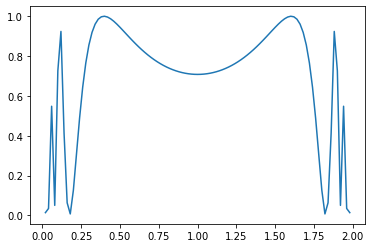

In [5]:
w = np.linspace(0., 2., endpoint=False, num=100)[1:] 
def f(x):
    return pow(np.sin(1./(x*(x-2))),2)
def f_neg(x):
    return -pow(np.sin(1./(x*(x-2))),2)
x_f_max = optimize.minimize_scalar(f_neg, method='bounded', bounds=[0, 2])
f_max = f(x_f_max.x)
plt.figure()
plt.plot(w,f(w))

n = 100000
u = np.random.uniform(0.00000001, 2, n)
r = np.random.uniform(0, 1, n)
a = r[r < f(u)]
p = len(a)/n
I_HorM = 2*p
sigma_HorM = 2*np.sqrt(p*(1-p)/n)
rel_err_HorM = sigma_HorM/I_HorM
print(I_HorM, "±", sigma_HorM)

v = np.random.uniform(0.00000001, 2, n)
I_mvm = (2./n)*np.sum(f(u))
sigma_mvm = 2*(np.var(f(v)))/np.sqrt(n)
print(I_mvm, "±", sigma_mvm)
rel_err_mvm = sigma_mvm/I_mvm
print(rel_err_HorM, "vs", rel_err_mvm)

4\. **Monte Carlo integration in high dimension**

* Start of by computing the area of a circle of unit radius, by integrating the function 

$$
f(x,y)=
\left\{
\begin{array}{ll}
      1 & x^2+y^2\le 1 \\
      0 & {\rm elsewhere}
\end{array} 
\right.
$$

* Generalize the result for a 10D sphere



In [10]:
def create_circle(dim, n):
    w = np.random.uniform(-1, 1, (1,n))
    for i in range(dim-1):
        w=np.append(w, np.random.uniform(-1, 1, (1,n)), axis=0)
    return w

def circle_ndim_area(dim, x):
    norm = np.linalg.norm(x,axis=0)
    p = np.count_nonzero(norm < 1)
    return pow(2.,dim)*(p/n)

def analytical_circle_ndim_area(dim):
    return np.pi**(dim/2)/math.gamma(dim/2 + 1)

dim = 2
n = 1000000
u = create_circle(dim,n)
circle_2D_area = circle_ndim_area(dim, u)
print("area cerchio 2D, MC:", circle_2D_area, "vs analitica:", analytical_circle_ndim_area(dim))

dim = 10
v = create_circle(dim,n)
circle_10D_area = circle_ndim_area(dim, v)
print("area cerchio 10D, MC:",circle_10D_area,"vs analitica:",analytical_circle_ndim_area(dim))

area cerchio 2D, MC: 3.142816 vs analitica: 3.141592653589793
area cerchio 10D, MC: 2.44224 vs analitica: 2.550164039877345


5\. **Monte Carlo integration with importance sampling** 

Calculate the value of the integral:

$$
I=\int_0^1 \frac{x^{-1/2}}{e^x+1} dx
$$

using the importance sampling method with $w(x)=1/\sqrt{x}$. You should get a result about 0.84

the value of the integral between 0 and 1 is 0.8395266689807429


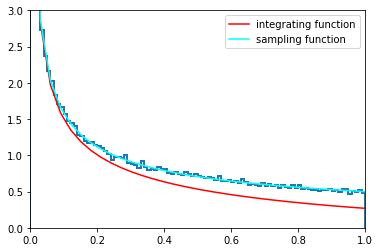

In [11]:
a=np.linspace(0.000001,1,100)

n = 100000
def my_func(x):
    return (1./np.sqrt(x))/(pow(math.e,x)+1)
def my_pdf(x):
    return 1./(2*np.sqrt(x))
def my_icdf(z):
    return pow(z,2)

u = np.random.random(n)
v = my_icdf(u)
z = np.random.random(n)
w = my_icdf(z)
I_is = (1.0/n) * np.sum(my_func(v)/my_pdf(v))
print("the value of the integral between 0 and 1 is", I_is)

a=np.linspace(0.000000000001,3,100)
plt.figure()
plt.axis([0.000000000001,1,0,3])
plt.plot(a,my_func(a),color="red", label="integrating function")
plt.hist(v, histtype='step', bins=100, density=True, linewidth=2)
plt.plot(a, my_pdf(a), color="cyan", label="sampling function")
plt.legend()
plt.show()